# ケプストラム法による基本周波数系列の推定

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.io import wavfile
import librosa

In [2]:
IN_WAVE_FILE = "in.wav"         # 分析対象の音声

FRAME_LENGTH = 1024             # フレーム長 (FFTサイズ)
HOP_LENGTH = 80                 # フレームのシフト長
FFT_LENGTH = FRAME_LENGTH

In [3]:
MAX_Fo = 200                # 分析における基本周波数の最大値 (Hz)
MIN_Fo = 60                 # 分析における基本周波数の最小値 (Hz)

THRESHOLD_dB = -30          # 無声判定のしきい値 in dB

In [4]:
# 音声のロード
fs, data = wavfile.read(IN_WAVE_FILE)
data = data.astype(np.float64)

In [5]:
# フレーム化
frames = librosa.util.frame(data, frame_length=FRAME_LENGTH,
                            hop_length=HOP_LENGTH).T

# 各フレームで計算したパワーをもとに有声音のフレームを決定（泥臭い）
powers = np.sum(frames * frames, axis=1)
voiced = np.where(10 * np.log(powers / np.max(powers)) > THRESHOLD_dB)

# 窓掛け
window = scipy.signal.blackman(FFT_LENGTH)
windowed_frame = frames[voiced] * window

In [6]:
# ケプストラムの計算 (FFT → 絶対値 → 対数 → 逆FFT)
fft_spec = scipy.fft.rfft(windowed_frame)
log_amp_spec = np.log(np.abs(fft_spec))
cepstrum = scipy.fft.irfft(log_amp_spec)

In [7]:
# ケプストラムの最大次数、最小次数
max_cep_order = int(np.floor(fs / MIN_Fo))
min_cep_order = int(np.floor(fs / MAX_Fo))

# ピーク位置の検出
peak_index = np.argmax(cepstrum[:, min_cep_order:max_cep_order], axis=1)
max_quef = peak_index + min_cep_order

# ケフレンシから変換して基本周波数の推定
fo = fs / max_quef

# 基本周波数の系列：無声音のフレームでは 0 Hzとするため 一様に0で初期化
fo_seq = np.zeros(frames.shape[0])

# 有声音のフレームに 推定された基本周波数を格納する
fo_seq[voiced] = fo

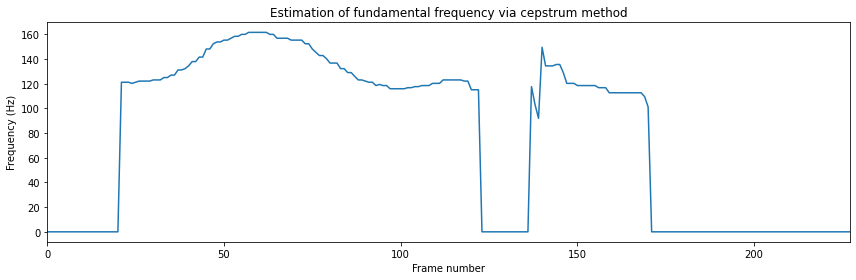

In [8]:
# 基本周波数の系列を表示
fig = plt.figure(figsize=(12, 4))
plt.plot(fo_seq)
plt.xlabel("Frame number")
plt.ylabel("Frequency (Hz)")
plt.title("Estimation of fundamental frequency via cepstrum method")
plt.tight_layout()
plt.xlim(0, len(fo_seq) - 1)

plt.show()